In [1]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from loss import custom_loss

from loss import *
from models import *
from OptimizedDataGenerator import OptimizedDataGenerator

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-02-20 01:21:15.217001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 01:21:15.217080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 01:21:15.218503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 01:21:15.226171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 01:21:17.985887: W tensorflow/compiler/tf2

In [2]:
fingerprint = 'f56e50db'
# c9ce48b7
model = CreateModel((13,21,2), n_filters=5, pool_size=3)

base_dir = f'./trained_models_mdmm/model-{fingerprint}-checkpoints'
checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
training_cp_path = os.path.join(base_dir, 'training_log.csv')
training_history = pd.read_csv(training_cp_path)

print(f"Loading model from {latest_checkpoint}")
model.load_weights(latest_checkpoint)

2025-02-20 01:21:27.172249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:81:00.0, compute capability: 8.0
2025-02-20 01:21:27.353883: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loading model from ./trained_models_mdmm/model-f56e50db-checkpoints/weights.99-t-19456.30-v-18767.18.hdf5


In [3]:
def calculate_sparsity(model, epsilon):
    zero_count = 0
    total_count = 0
    for layer in model.layers:
        if layer.weights:
            weights = layer.get_weights()[0]
            zero_count += np.sum(np.isclose(weights, 0, atol=epsilon))
            total_count += weights.size
    return zero_count / total_count if total_count > 0 else 0

model_sparsity = calculate_sparsity(model, epsilon = 1e-3)
print(f"Model Sparsity: {model_sparsity*100:.2f} %")

Model Sparsity: 67.14 %


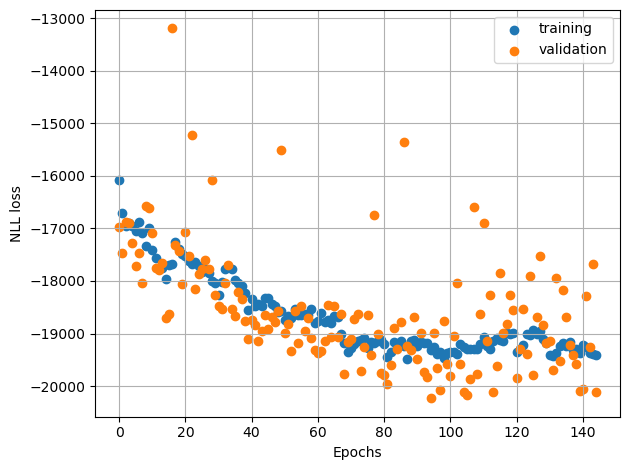

In [4]:
plt.scatter(training_history['epoch'], training_history['loss'])
plt.scatter(training_history['epoch'], training_history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.tight_layout() 

plt.savefig(os.path.join(base_dir,'training_hist.png'))
plt.show()

In [5]:
print(training_history.to_string())


     epoch          loss      val_loss
0        0 -16078.301758 -16966.767578
1        1 -16699.554688 -17461.626953
2        2 -16945.566406 -16884.066406
3        3 -16893.507812 -16901.113281
4        4 -16953.617188 -17268.316406
5        5 -17042.511719 -17709.687500
6        6 -16883.859375 -17459.542969
7        7 -17090.896484 -18037.001953
8        8 -17333.871094 -16583.144531
9        9 -16998.710938 -16606.675781
10      10 -17407.595703 -17090.636719
11      11 -17571.927734 -17752.550781
12      12 -17766.886719 -17794.167969
13      13 -17746.648438 -17657.160156
14      14 -17957.070312 -18697.957031
15      15 -17691.027344 -18624.833984
16      16 -17674.613281 -13196.667969
17      17 -17263.570312 -17310.558594
18      18 -17393.128906 -17422.898438
19      19 -17488.025391 -18052.111328
20      20 -17529.265625 -17059.847656
21      21 -17627.812500 -17530.632812
22      22 -17686.238281 -15224.980469
23      23 -17644.281250 -18158.632812
24      24 -17722.328125 

In [6]:
tfrecords_dir_val = "/depot/cms/users/das214/tfrecords_2t_val_d8"
test_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_val,
)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [8]:
# predicts test data
p_test = model.predict(test_generator)

 4/59 [=>............................] - ETA: 1s  

2025-02-20 01:21:30.979509: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


59/59 [==============================] - 8s 111ms/step


In [9]:
complete_truth = None
for _, y in tqdm(test_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 59/59 [00:06<00:00,  9.12it/s]


In [10]:
# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

In [11]:
# fig, axes = plt.subplots(2,2,figsize=(8,6))
# fig.tight_layout(pad=4.0)
# residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
# axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
# axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
# residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
# axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
# axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
# residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
# axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
# residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
# axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

# save_fig_path = os.path.join(base_dir, 'summary.png')
# plt.savefig(save_fig_path)

# residuals (mean, stdv)

In [12]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(0.7900822442024946, 11.449544504284859)

In [13]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(-0.5988292163237929, 2.3998914286494255)

In [14]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(0.028572900220751762, 0.3151809871196747)

In [15]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(0.013493080623447895, 0.0678359717130661)

# x residuals

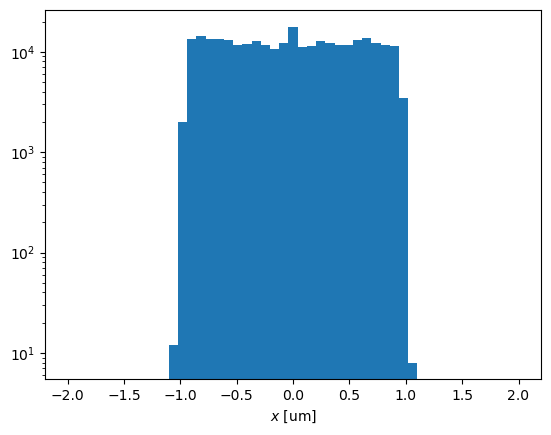

In [16]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

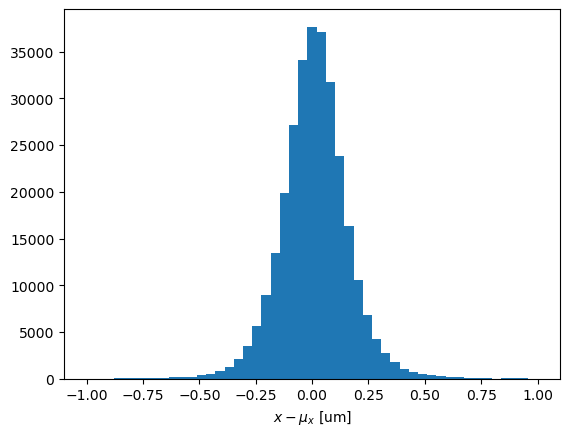

In [17]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

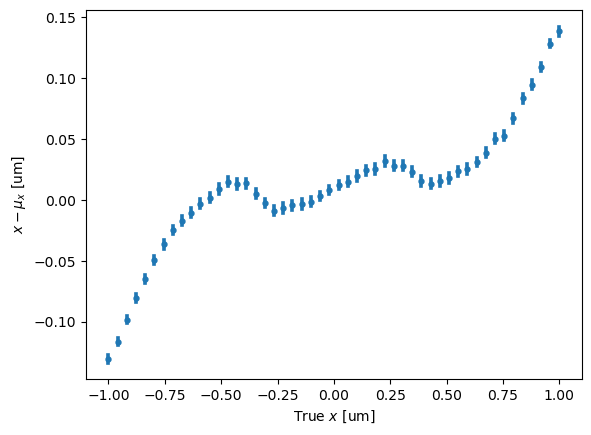

In [18]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

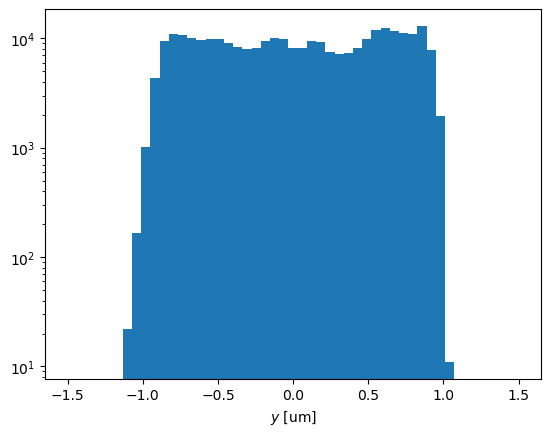

In [19]:
plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

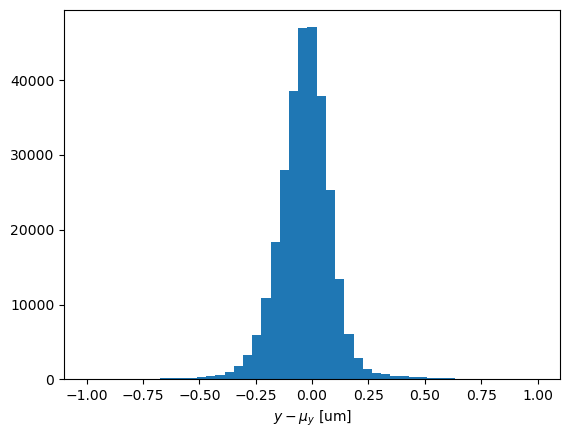

In [20]:
plt.hist(residualsy,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

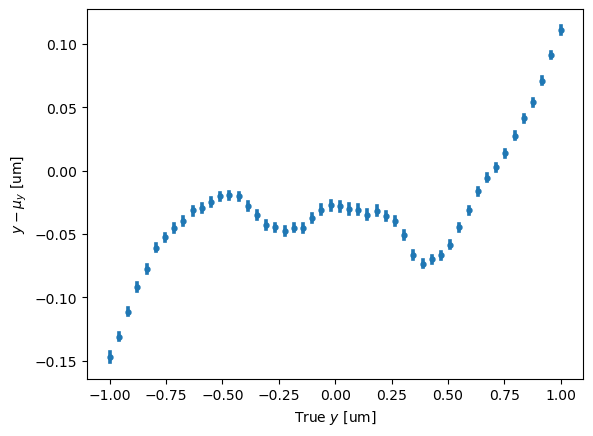

In [21]:
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

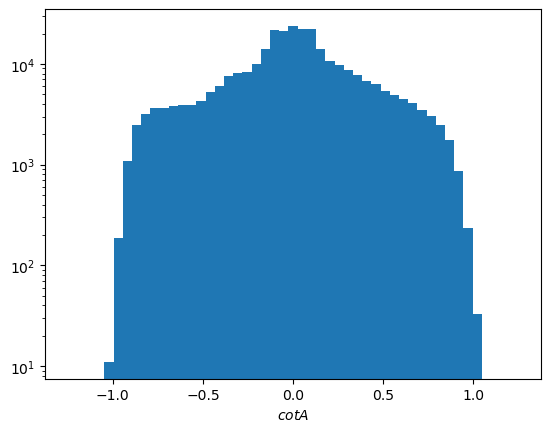

In [22]:
plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.yscale('log')
plt.xlabel(r'$cotA$')

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

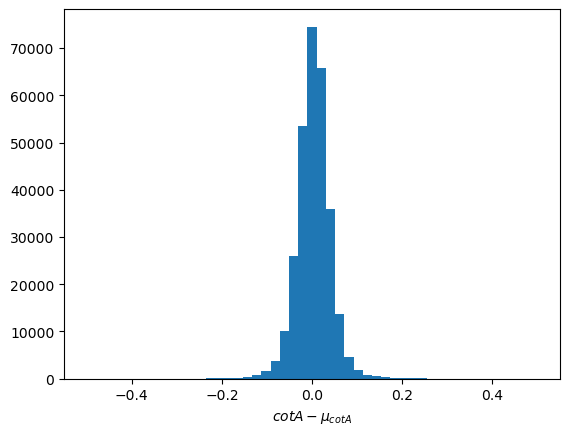

In [23]:
plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

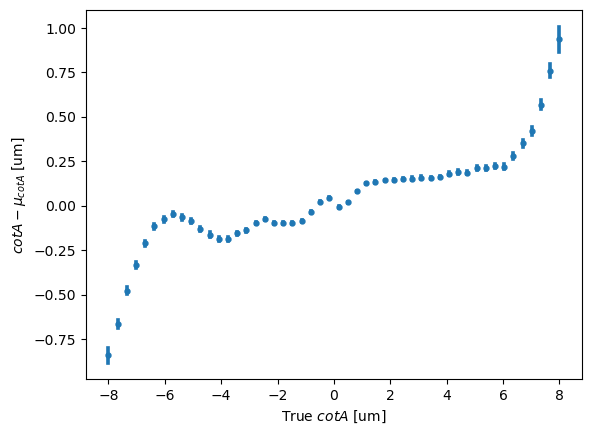

In [24]:
x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.')
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

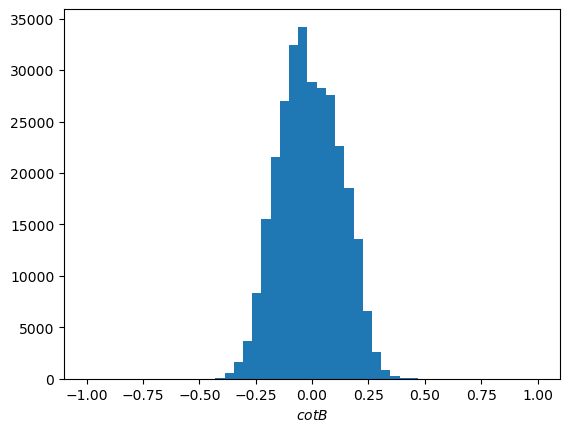

In [25]:
plt.hist(p_test[:,6]*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

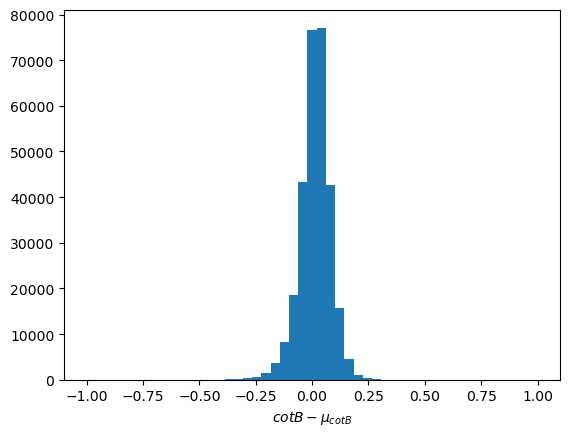

In [26]:
plt.hist(residualsB*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

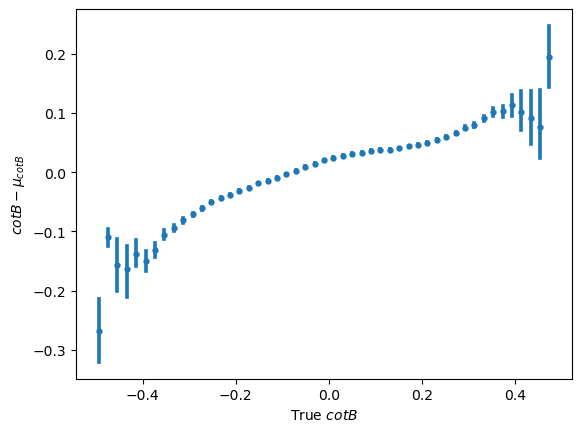

In [27]:
x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [28]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

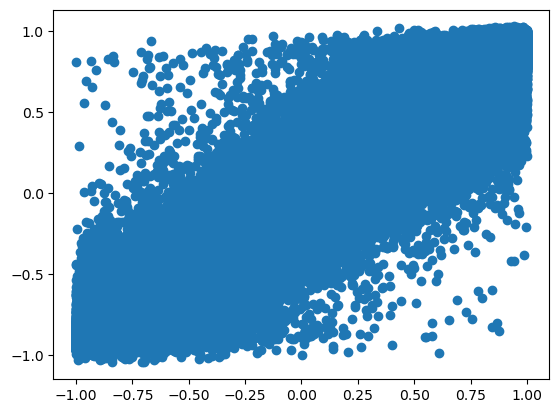

In [29]:
plt.scatter(df['xtrue'],df['x'])
plt.show()

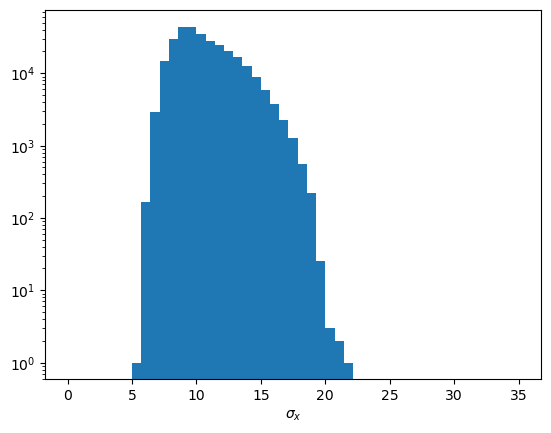

In [30]:
plt.hist(df['sigmax'] * 75,bins=np.linspace(0,35,50))
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')

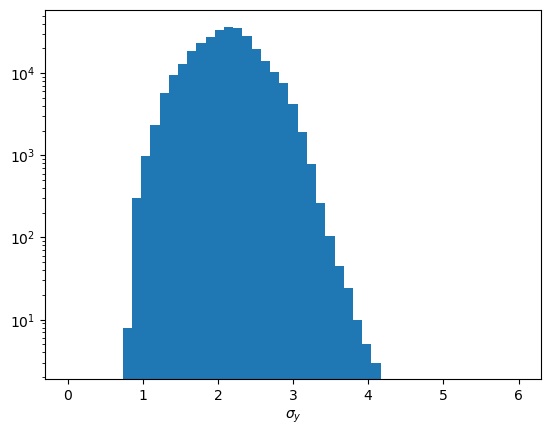

In [31]:
plt.hist(df['sigmay']* 18.75,bins=np.linspace(0,6,50))
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')

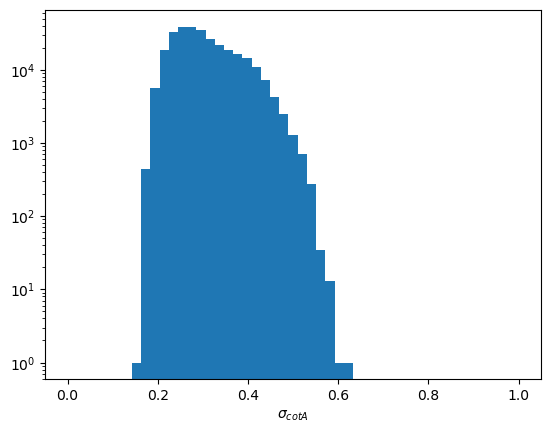

In [32]:
plt.hist(df['sigmacotA'] * 8,bins=np.linspace(0,1.0,50))
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')

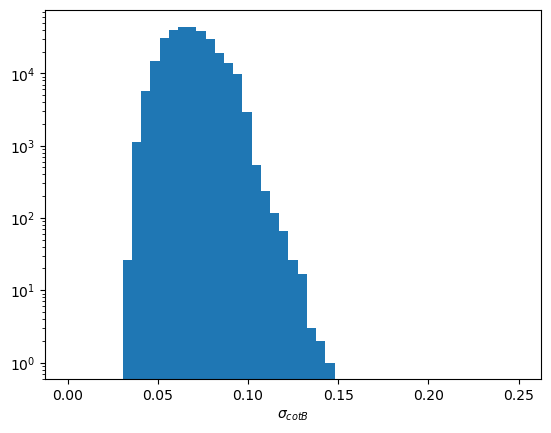

In [33]:
plt.hist(df['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50))
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')

In [34]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name, unit_gauss = True, log_scale = True):
    
    h = ax.hist(df[var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    if log_scale: ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-5,5,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black', label='Fitted Gaussian')
    if unit_gauss: ax.plot(xbins,gauss(xbins,pars[0],0, 1),color='red', label='Unit Gaussian')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-5,20000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-5,10000,"$\sigma$="+str(round(abs(pars[2]),2)))

    ax.legend()

Mean 0.039530825998705534
Sigma -0.9167756092564615
Mean -0.2924552417310066
Sigma 0.8883625373248638
Mean 0.06413553329515614
Sigma -0.8475821264058309
Mean 0.252449731931283
Sigma 0.8478279489400451


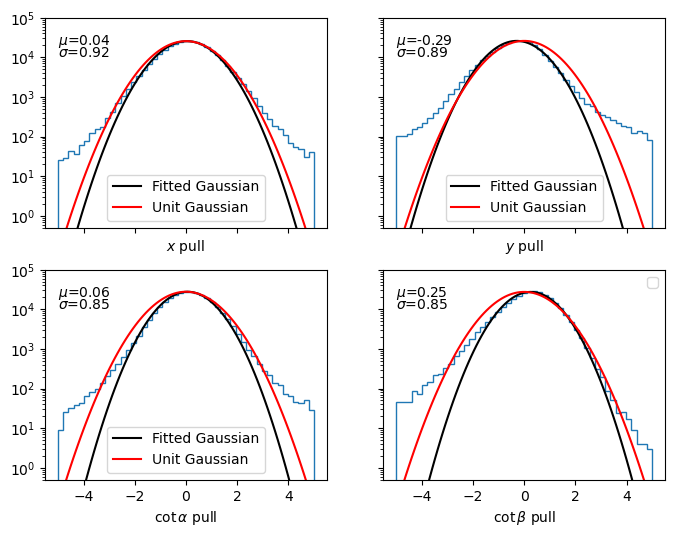

In [35]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

plt.legend([])

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [36]:
epsilon = 1e-1
target_sparsity = 0.5
scale = 1.0
damping = 1.0

In [37]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue


/tmp/ipykernel_627853/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_627853/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


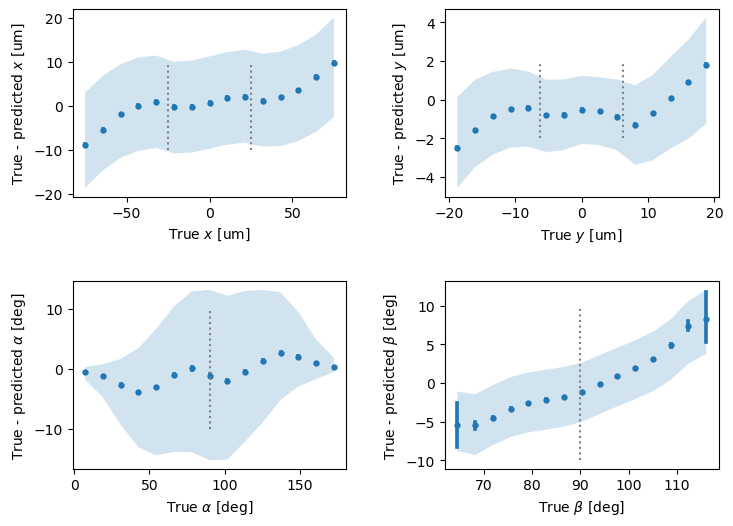

In [38]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)